## Preparation

     colab -> 런타임 -> 런타임 유형 변경 -> GPU -> 저장

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import argparse
import numpy as np
import time
import math
from copy import deepcopy # Add Deepcopy for args
import matplotlib.pyplot as plt
from IPython.display import HTML
import torchsummary

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# dummy class
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

class Densenet(nn.Module):
    def __init__(self):
        super(Densenet, self).__init__()

def print_acc_class(net, partition):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                         batch_size=args.test_batch_size,
                                         shuffle=False, num_workers=0)
    net.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

def plot_loss_variation(result, **kwargs):

    '''
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    '''
    list_data = []
    for epoch, train_loss in enumerate(result['train_losses']):
        list_data.append({'type': 'train', 'loss': train_loss, 'epoch': epoch})
    for epoch, val_loss in enumerate(result['val_losses']):
        list_data.append({'type': 'val', 'loss': val_loss, 'epoch': epoch})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)


def plot_acc_variation(result, **kwargs):
    list_data = []
    for epoch, train_acc in enumerate(result['train_accs']):
        list_data.append({'type': 'train', 'Acc': train_acc, 'test_acc': result['test_acc'], 'epoch': epoch})
    for epoch, val_acc in enumerate(result['val_accs']):
        list_data.append({'type': 'val', 'Acc': val_acc, 'test_acc': result['test_acc'], 'epoch': epoch})


    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric, horizontalalignment='left', verticalalignment='center',
                 transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=0)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc


def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=0)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc


def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=0)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc



def experiment(partition, args):
    if args.model == 'CNN':
        net = CNN()
    elif args.model == 'Resnet':
        net = Resnet()
    elif args.model == 'Densenet':
        net = Densenet()
    else:
        raise ValueError('In-valid model choice')
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            'Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch,
                                                                                                                  train_acc,
                                                                                                                  val_acc,
                                                                                                                  train_loss,
                                                                                                                  val_loss,
                                                                                                                  te - ts))

    test_acc = test(net, partition, args)
    print_acc_class(net, partition)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('ready.')

Files already downloaded and verified
Files already downloaded and verified
ready.


### 2.4 Going deeper: Case studies
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide74.PNG?raw=true)

    ImageNet 데이터 베이스를 이용해서 1000개의 클래스에 대한 top-5 error 그래프입니다.
    cifar에 비해서 이미지도 크고(227x227x3) 분류해야될 클래스도 많기 때문에 어렵겠죠? 데이터셋도 더 크구요.
    이 network들이 어떠한 테크닉을 사용하였는지, case study를 통해 같이 살펴보겠습니다.
***



### 3.4 Going deeper: Case studies
### 3.4.2 AlexNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide71.PNG?raw=true)

    CNN을 사용해서 Imagenet Challange에서 우승한 최초의 딥러닝 네트워크인 alexnet입니다.
    논문에도 아키텍쳐 다이어그램이 위에 짤린것으로 나타내는 데, 정확히는 모르겠지만 의도적으로 한것같다.
    이 아키텍처 다이그램이 보통적으로 보이지 않는 이유는 2gpu를 사용해서 큰 모델을 학습시키기 위해서,
    two-stream network입니다.
    학습하는데, 6일이 걸렸음, 지금은 몇분만에 학습가능
    alexnet의 특징은 처음으로 CNN을 제대로 사용할 수 있다고 말씀드릴 수 있겠는데요,
    첫번째는 vanishing Gradient 문제를  해결하기위해 ReLU를 사용했으며,
    overfitting을 피하기 위해 dropout, weight decay를 사용했습니다.
    weight decay는 특정한 weight값이 너무 크면 큰 만큼 값을 줄여줘서(부식시킨다) regularization해주는 겁니다.
    (신경망이 범용성을 갖도록 처리하는 거니까 regularization은 일반화 정도라고 생각하시면됩니다 normalization, 정규화와는 다른의미입니다.)
***

### 3.4 Going deeper: Case studies
### 3.4.2 AlexNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide72.PNG?raw=true)

    alexnet을 단순화 시켜보면 이렇습니다. input을 conv, non-linaer, pooing 반복반복,
    마지막에 fcfcfc, lenet, cnn의 기본구조와는 거의 차이가없죠? 그래서 이 친구 같은 경우는 아직 advanced cnn은 아니다.
    처음으로 convolution layer를 dnn에 잘 적용했기때문에 다뤄보았구요,
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/Lec6-A.pdf_page_17.png?raw=true)

    이제부터 중요해지는 그 다음것을 봅시다.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide75.PNG?raw=true)

    VGGNet은 2014년도에 2위를 한 oxford대학의 네트워크입니다. 1위는 GoogLeNet이 했죠.
    이 네트워크를 다루는 이유는 VGGNet의 네트워크 디자인 룰이 간단하고 효과적이기 때문에 아직까지도 많은 영향을 미치고 있기 때문입니다.
    네트워크를 간단히 살펴보자면, conv,conv,pooling -> .... -> conv,conv,conv,conv,poopling,fcfcfc 구조네요.
    conv를 연속적으로 한다는 것 빼고는 딱히 alexnet과 큰 차이는 없지만, 우리는 Design rule을 볼 필요가 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/498_FA2019_lecture08.pdf_page_041.png?raw=true)

    첫번째 디자인 룰은 same convolution을 합니다. 위에서 한번 말씀드렸듯이 padding 1을 추가해서 feature map이 작아지는 것을
    방지하여 좀 더 깊은 네트워크를 만들 수 있게 합니다. 그리고 conv-pooling을 하는 이전과는 다르게 conv-conv-pooling을 하는
    구조를 보실 수 있으실텐데요, 우리는 가로세로 5칸의 window를 featuremap에 담고싶다고 하면,
    (이 윈도우를 receptive field라 위에서 말씀드렸죠?) 5x5 conv를 한번 하는것보다,
    3x3을 두번 하는 것이 효과적이다라는 것을 찾아내었기 때문인데요, 아래보시면
    파라미터 수와 실수연산은 더 적은데 같은효과 오히려 non-linearity를 두 번 적용한 더 좋은 결과가 나온다는 것을 보실 수 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide76.PNG?raw=true)
    두번째, 첫번째 레이어의 5x5 receptive filed를 보는 것과 같은 효과라는 것을 도식화 한 그림입니다.
    왜냐하면 첫번째 conv-layer를 통과한 fateure-map의 한 칸이 input 3x3 정보를 담고 있기 때문이죠.
***

### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/498_FA2019_lecture08.pdf_page_044.png?raw=true)

    두번째 룰은 plooing을 할때, feature map을 반으로 줄이고 채널 수를 두배로 키워줍니다.
    이 룰은 아주 많은 cnn 아키텍쳐들이 따르고 있는 룰인데요,
    각 conv스테이지마다 메모리는 줄이고 실수 연산cost는 유지하고 싶었기 때문입니다.
    (Memory=H*W*C , Params=c_in*c_out*k_h*k_w, Params=(k_h*k_w*k_z)*filters_num, FLOPs=(c_out*h*w)*(c_in*k_h*k_w)
***


### 3.4 Going deeper: Case studies
### 3.4.3 VGGNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide77.PNG?raw=true)

    이 그래프는 VGG의 imagenet top-5 error인데요, 16레이어까지는 깊게 깧을 수록 에러가 낮아지는 것을 볼 수 있는데,
    더 깊게 쌓으면 에러가 차라리 높아지는 것을 볼 수 있습니다.
    깊어질수록 많아지는 연산량과 weight paramter들을 optimize를 하는 것이 어려움을 어떠한 네트워크 디자인을
    통해 극복했는지 살펴보도록 합시다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: Inception module
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide92.PNG?raw=true)

    14년도 Imagenet challange(ILSVRC) 1위를 한 GooLeNet입니다. 2위는 VGG구요.
    GooLeNet에서 중간에 L자가 대문자인 이유는 얀르쿤교수팀이 개발한 Lenet을 shoutout하는 의미로 하였구요.
    네트워크 아키텍쳐가 조금 복잡해보이는데요, 가장 눈에 띄는점은 뭐 이렇게 묶음이 있구요, 중간중간 곁가지 처럼 나온게 있네요.
    이 묶음이랑 곁가지를 제외하고 본다면 일반적인 CNN구조와 유사하게 매우 단순한 구조로 가지고 있습니다.

    우선 옆으로 나온 곁가지에 대해 설명드리자면, 끝에서 나온 loss는 초반부 layer에 영향이 약해지는 vanishing gardient문제를
    조금이라도 보완하고자, 중간중간 loss도 뽑아서 역전파를 시키자는 trick입니다.
    15년도에 batch normalizaion이라는 학습 방법이 나온 뒤는 더이상 사용하지 않습니다.

    그럼 이 묶음은 뭘까요? 이 묶음에 대해서 자세히 알아보도록 합시다.

***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: Inception module
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide93.PNG?raw=true)

    이 묶음의 이름은 inception module이라고 합니다.
    영화 인셉션에서 "우리는 좀더 깊이 들어가야해."라는 대사가 나옵니다. 영화에선 꿈의 심연을 뜻하는거겠죠?
    딥러닝에서도 좀 더 깊이 네트워크를 쌓고자하는 바램에서 inception이란 이름을 따왔습니다.

    inception module을 크게 확하면 왼쪽과 같은데, parallel한 구조를 가지고 있습니다.
    1x1 conv를 빼고보자면, 그냥 input도 넘겨주고,
    3x3 conv한 것도 넘겨주고, 5x5 conv한것도 넘겨주고, 3x3 pooling 한것도 넘겨주네요,
    한가지 input에 대해서 동시에 다양한 방면으로 본다는 의미에서 좋아 보입니다. 그리고 마지막에 합치는 것을 볼 수 있네요
    여기서 합치는 것을 concatenate, stack 이라고 부르는데 값을 합치는 것이 아닌, 단순히 채널들을 순서대로 쌓는다는 의미입니다.

    1x1 conv는 이렇게 합치다보면 너무 channel이 두꺼워지니까 1x1 conv를 통해 줄이는 연산입니다.
    넓이와 높이를 줄이는데 pooling이 있듯이 channel을 줄이는데는 1x1 conv를 사용할 수 있으며
    이 레이어를 병목처럼 줄인다고하여 bottleneck layer라고 합니다.

    좀 더 쉽게 설명하자면 식빵이 들어오면, 이 식빵을 4개로 잘라서 다양한 4명의 사람이 살펴보고 특이한 것을 마킹을하고
    다시 식빵을 합치는 겁니다. 근데 식빵이 이 과정을 할때마다 두꺼워져서 양옆에서 손으로 한번씩 눌러줘서 원래크기 비슷하게 맞춰줍니다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/covariate_shift.jpg?raw=true)

    그리고 15년도에 batch norm이 나온 후 부터는 곁가지 트릭은 쓰지 않는다고 말씀드렸습니다.
    batch normalization, batch norm/bn이라고 부르는 이 방법은.
    학습시에 현재 layer의 입력은 모든 이전 layer의 파라미터의 변화에 영향을 받게 되며,
    망이 깊어짐에 따라 이전 layer에서의 작은 파라미터 변화가 증폭되어 뒷단에 큰 영향을 끼치게 되는 문제가 발생할 수 있습니다.
    마치 나비효과처럼요. 이것을 “Covariate Shift”라고 합니다.
    그래서 우리는 중간중간 이를 바로잡아줄 방법이 필요한데 이게 바로 batch norm입니다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide80.PNG?raw=true)

    학습은 mini-batch단위로 진행하기 때문에 mini-batch의 평균과 분산을 구해서, 데이터를 -1~1사이로 normalization을 시켜줍니다.
    우리는 normalization에 scale값과 shift를 추가하여 이 변수도 같이 학습을 통해 정하게 하여,
    전체 dataset을 normalization을 해주는 factor를 찾게하여 단순하게 정규화만을 할 때 보다 훨씬 강력하게 만듭니다.

***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide81.PNG?raw=true)

    구글의 inception-v2부터는 bn을 적용하는데, 보시는 것처럼 같은 네트워크에서 bn이 없을때와 bn이 있을때
    얼마나 잘 network 학습하는지, 정확도가 나오는지 증명하고 있습니다.
    학습 진도율을 키운 BN-x30의 경우는 기존 Inception 보다 6배 빠르게 학습되며 더 높은 정확도에 도달할 수 있었습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.5 GooLeNet: batch normalization
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/lecture_1_ranjay.pdf_page_10.png?raw=true)

    batch norm과 다양한 딥러닝 학습 테크닉의 발견으로 우리는 더 network를 깊게 쌓을 수 있었습니다.
    15년도 이후 논문들의 layer수를 보면 갑자기 100개 넘는 것을 볼 수 있습니다.
    정확도도 눈에 띄게 향상됬구요.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/498_FA2019_lecture08.pdf_page_060.png?raw=true)

    Batch norm을 이용해서 10개 이상의 레이어를 학습시킬 수 있게됬습니다.
    그런데 오른쪽에 보이는 것처럼 Test dataset에 대한 에러는 56개를 쌓은 에러가 더 높네요.
    아마도 레이어가 깊다보니 학습데이터 셋을 외워버리는 overfitting일 일어난 것 같습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/498_FA2019_lecture08.pdf_page_061.png?raw=true)

    그런데 training error도 20개를 쌓은 비교적 shallow한 network보다 에러가 높습니다.
    사실은 overfitting이 아닌 학습이 잘 되지않은 underfitting이 일어난 겁니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/498_FA2019_lecture08.pdf_page_063.png?raw=true)

    깊은 모델은 얕은 모델보다 더 성능이 잘 나와야합니다.
    예를들어 20개의 layer를 가진 모델 뒤에 아무런일을 하지 않는 36개 레이어를 붙인다고해도 성능이 떨어질 이유는 없기 때문이죠.
    여기서 깊은 네트워크는 가장 낮은 loss를 찾는 weight를 optimize를 찾기힘들것이라는 추측을 합니다.
    그래서 우리는 앞에 20개의 레이어를 유지하면서 뒤에 36개는 조금만 추가적으로 일해도 잘 나올것이다라는 생각처럼,
    앞에 레이어의 정보를 유지하면서 추가 정보를 붙이는 identity function을 설계하게 됩니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide82.PNG?raw=true)

    이 그림은 resnet의 residual block이라고 부르는 module입니다.
    inception module처럼 resnet도 이 residual block을 반복하면서 네트워크를 만듭니다.
    위에서 언급했었것 처럼 indentity를 유지하기위해 input그대로와 convolution결과를 더합니다.
    여기서 더하는 것은 inception module처럼 concatenate를 하는 것은 아니고 두 레이어를 더하는 겁니다.
    역전파를 할 때 더하기 연산은 값을 그대로 복사하기 때문에 이전 feature 공유의 indentity를 유지할 수 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide84.PNG?raw=true)

    이렇게 residual block을 쌓아서 18개부터 152개 까지의 다양한 resnet 아키텍쳐를 만듭니다.
    보시면 inception구조처럼 1x1 conv를 통해서 채널 수를 줄여주고 있는 것을 보실 수 있습니다.
    이 방법을 통해서 깊게 쌓으면서도 연산은 VGG-16(13.6)보다 적게 사용하고 있습니다.
***

### 3.4 Going deeper: Case studies
### 3.4.6 ResNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/498_FA2019_lecture08.pdf_page_079.png?raw=true)

    이 모델 아키텍쳐는 기대한대로 깊게 쌓을수록 네트워크 성능이 좋아진다는 것을 증명하였고,
    resnet을 backbone으로 한 5개의 challage 분야에서 1위를 달성했습니다.
    매우 심플한 network design에 좋은 성능을 내어 아직까지도 많이 사랑받는 network입니다.

    그럼 실습을 통해 Resnet구현을 해보겠습니다.
***

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1_1x1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2_3x3 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3_1x1 = nn.Conv2d(planes, 4*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(4*planes)
        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != 4*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, 4*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(4*planes)
            )


    def forward(self, x):
        out = self.relu(self.bn1(self.conv1_1x1(x)))
        out = self.relu(self.bn2(self.conv2_3x3(out)))
        out = self.bn3(self.conv3_1x1(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# resnet-50
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.inplanes = 64
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # for cifar-10
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.residual_block(64, 3, stride=1)
        #self.layer1 = self.residual_block(64, 1, stride=1)
        self.layer2 = self.residual_block(128, 4, stride=2)
        #self.layer2 = self.residual_block(128, 2, stride=2)
        self.layer3 = self.residual_block(256, 6, stride=2)
        #self.layer3 = self.residual_block(256, 4, stride=2)
        self.layer4 = self.residual_block(512, 3, stride=2)
        #self.layer4 = self.residual_block(512, 1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 10)


    def residual_block(self, planes, blocks, stride=1):
        layers = []
        layers.append(Bottleneck(self.inplanes , planes, stride))
        self.inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
#models = ['CNN', 'Resnet']
args.model = 'Resnet'
args.act = 'relu'
args.l2 = 0.00001
args.optim = 'SGD'  # 'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 1e-3
args.epoch = 300

args.train_batch_size = 256
args.test_batch_size = 64


#torchsummary.summary(Resnet().cuda(), (3, 32, 32))
print(args)
setting, result = experiment(partition, deepcopy(args))
plot_loss_variation(result)
plot_acc_variation(result)


Namespace(act='relu', epoch=300, exp_name='exp1_lr', l2=1e-05, lr=0.001, model='Resnet', optim='SGD', test_batch_size=64, train_batch_size=256)
Epoch 0, Acc(train/val): 25.68/24.98, Loss(train/val) 2.06/3.96. Took 74.30 sec
Epoch 1, Acc(train/val): 41.50/42.62, Loss(train/val) 1.65/1.62. Took 73.59 sec
Epoch 2, Acc(train/val): 47.96/50.38, Loss(train/val) 1.45/1.45. Took 73.81 sec
Epoch 3, Acc(train/val): 53.59/54.34, Loss(train/val) 1.30/1.42. Took 74.04 sec
Epoch 4, Acc(train/val): 58.02/55.54, Loss(train/val) 1.18/1.27. Took 73.70 sec


### 3.4 Going deeper: More case studies
### 3.4.7 DenseNet
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide86.PNG?raw=true)

    Vanishing Gradient 개선, Feature Propagation 강화, Feature Reuse, Parameter 수 절약이라는 이점

    ResNet과 같은 연결방식은 위와 같이 residual을 더하는 방식으로 생겼다.
    이전 레이어의 output을 다음의 레이어의 output과 합해서 더한다는 점에서, 정보들이 이후의 레이어들로 온전히 흘러가는 것을 방해할 수 있다는 약점이 있었다.
    Layer간의 정보가 흘러가는 것을 개선하기 위해, DenseNet에서는 ResNet과는 조금 다른 연결 패턴을 제안했다.
    이 수식에서 중요한 것은 x_0 ... x_l-1 을 더하지(sum) 않고 이어붙였다는(concatenation) 것이다.
    DesNet 수식의 function H는 위와 같이 x가 concatenation 된 함수로 구성된다.
    Transition layer : batch normalization -> 1x1 conv -> 2x2 average pool(stride2)
    Composite function :  Batch Normalization -> ReLU -> 3x3 Conv Layer

    dense block이 m 개의 feature-map을 포함하는 경우 다음 transition layer에서 출력 feature-map을 [θmc]개가 생성된다.
    여기서 0 <θ≤1은 compression factor라고 한다. (θ 가 1인 경우에는 transition layer의 특징맵 개수가 변경되지 않는다)
    θ<1 인 DenseNet을 DenseNet-C라고 칭하며, 실험에서는 θ=0.5로 설정한다.
    또한, bottleneck layer와 θ<1 인 transition layer를 모두 사용하는 모델은 DenseNet-BC

    growth_rate = 4
    compression factor = 0.5
    input = 6
    [6 -> (6)+4 -> (6+4)+4 -> (6+4+4)+4 -> (6+4+4+4)+4 = 22(32x32x22)] DenseBlock x 3
    -(transition)> (16x16x11) (16은 2x2풀링, 11은 1x1 factor 0.5)
    마지막에 Nx8x8 -(global avg pooling)> Nx1x1 -(flatten)> FC
***

Namespace(act='relu', epoch=300, exp_name='exp1_lr', l2=1e-05, lr=0.001, model='Densenet', optim='SGD', test_batch_size=64, train_batch_size=128)
Epoch 0, Acc(train/val): 22.70/23.04, Loss(train/val) 2.06/2.22. Took 93.33 sec
Epoch 1, Acc(train/val): 33.10/27.33, Loss(train/val) 1.77/2.11. Took 93.51 sec
Epoch 2, Acc(train/val): 37.86/25.34, Loss(train/val) 1.64/2.34. Took 93.03 sec
Epoch 3, Acc(train/val): 42.89/22.41, Loss(train/val) 1.54/3.08. Took 92.61 sec
Epoch 4, Acc(train/val): 45.48/31.87, Loss(train/val) 1.48/2.08. Took 92.58 sec
Epoch 5, Acc(train/val): 48.59/34.90, Loss(train/val) 1.41/2.21. Took 92.44 sec
Epoch 6, Acc(train/val): 49.27/37.33, Loss(train/val) 1.39/2.05. Took 92.31 sec
Epoch 7, Acc(train/val): 51.74/37.58, Loss(train/val) 1.33/2.22. Took 92.57 sec
Epoch 8, Acc(train/val): 53.44/46.39, Loss(train/val) 1.29/1.72. Took 93.22 sec
Epoch 9, Acc(train/val): 56.55/46.10, Loss(train/val) 1.21/1.81. Took 92.62 sec
Epoch 10, Acc(train/val): 58.63/45.95, Loss(train/val)

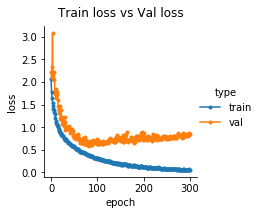

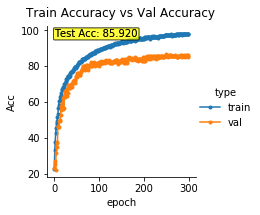

In [2]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, drop_rate=0.0):
        # out_planes => growth_rate를 입력으로 받게 된다.
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4  # bottleneck layer의 conv 1x1 filter chennel 수는 4*growth_rate이다.
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate
        self.dropout = nn.Dropout(p=drop_rate)

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.drop_rate > 0:
            out = self.dropout (out)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.drop_rate > 0:
            out = self.dropout (out)
        return torch.cat([x, out], 1)  # 입력으로 받은 x와 새로 만든 output을 합쳐서 내보낸다


class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, drop_rate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, drop_rate)

    def _make_layer(self, block, in_planes, growth_rate, nb_layers, drop_rate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes + i * growth_rate, growth_rate, drop_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, drop_rate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.drop_rate = drop_rate
        self.dropout = nn.Dropout(p=drop_rate)
        self.avg_pooling = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.drop_rate > 0:
            out = self.dropout(out)
        return self.avg_pooling(out)


class Densenet(nn.Module):
    def __init__(self, layers=121, num_classes=10, growth_rate=12, compression_factor=0.5, drop_rate=0.2):
        super(Densenet, self).__init__()
        num_of_blocks = 3
        n = (layers - num_of_blocks - 1) / num_of_blocks  # 총 layers에서 첫 conv , 2개의 transit , 마지막 linear 빼고 / num_of_blocks
        in_planes = 2 * growth_rate  # 논문에서 Bottleneck + Compression 할 경우 first layer은 2*growth_rate라고 했다.
        n = n / 2  # conv 1x1 레이어가 추가되니까 !
        block = BottleneckBlock


        n = int(n)  # n = DenseBlock에서 block layer 개수를 의미한다.
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1, padding=1,
                               bias=False)  # input:RGB -> output:growthR*2

        # 1st block
        # nb_layers,in_planes,growth_rate,block,drop_rate
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, drop_rate)
        in_planes = int(in_planes + n * growth_rate)  # 입력 + 레이어 만큼의 growth_rate

        # in_planes,out_planes,drop_rate
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes * compression_factor)), drop_rate=drop_rate)
        in_planes = int(math.floor(in_planes * compression_factor))

        # 2nd block
        # nb_layers,in_planes,growth_rate,block,drop_rate
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, drop_rate)
        in_planes = int(in_planes + n * growth_rate)  # 입력 + 레이어 만큼의 growth_rate

        # in_planes,out_planes,drop_rate
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes * compression_factor)), drop_rate=drop_rate)
        in_planes = int(math.floor(in_planes * compression_factor))

        # 3rd block
        # nb_layers,in_planes,growth_rate,block,drop_rate
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, drop_rate)
        in_planes = int(in_planes + n * growth_rate)  # 입력 + 레이어 만큼의 growth_rate

        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.ada_avg_pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_planes, num_classes)  # 마지막에 ave_pool 후에 1x1 size의 결과만 남음.

        self.in_planes = in_planes

        # module 초기화
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Conv layer들은 필터에서 나오는 분산 root(2/n)로 normalize 함
                # mean = 0 , 분산 = sqrt(2/n) // 이게 무슨 초기화 방법이었는지 기억이 안난다.
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):  # shifting param이랑 scaling param 초기화(?)
                m.weight.data.fill_(1)  #
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):  # linear layer 초기화.
                m.bias.data.zero_()

    def forward(self, x):
        # x : 32*32
        out = self.conv1(x)  # 32*32
        out = self.block1(out)  # 32*32
        out = self.trans1(out)  # 16*16
        out = self.block2(out)  # 16*16
        out = self.trans2(out)  # 8*8
        out = self.block3(out)  # 8*8
        out = self.relu(self.bn1(out))  # 8*8
        out = self.ada_avg_pooling(out)  # 1*1
        out = out.view(-1, self.in_planes)  # channel수만 남기 때문에 Linear -> in_planes
        return self.fc(out)

# layers,num_classes <- cifar '10' ,growth_rate=12,compression_factor=0.5,bottleneck=True,drop_rate=0.0


seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
#models = ['CNN', 'Resnet', 'Densenet']
args.model = 'Densenet'
args.act = 'relu'
args.l2 = 0.00001
args.optim = 'SGD'  # 'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 1e-3
args.epoch = 300

args.train_batch_size = 128
args.test_batch_size = 64



#torchsummary.summary(Densenet().cuda(), (3, 32, 32))
print(args)
setting, result = experiment(partition, deepcopy(args))
plot_loss_variation(result)
plot_acc_variation(result)

### 3.4 Going deeper: More case studies
### 3.4.7 Sqeeze-and-excitation networks
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide87.PNG?raw=true)


  dd

***

### 3.4 Going deeper: More Case studies
### 3.4.7 State-of-the-art
![pt](https://github.com/tiktakdad/dl4cv/blob/master/images/pt/Slide89.PNG?raw=true)

    g
***

